# TFs from CHROMVAR results

This notebook plots TFs from chromvar results.

**Dataset**: MIS-C dataset

**Type of cells**: HSPC

**DGE condition**: Different timepoints of disease status

**Inputs**: Filtered anndata object with HSPC cells only, ArchR project and chromvar scores

**Output 1**: Volcano plots

In [1]:
import rpy2
import anndata
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import warnings
import scipy
#%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#%load_ext rpy2.ipython

In [2]:
from adjustText import adjust_text
from matplotlib.backends.backend_pdf import PdfPages

# Inputs

In [3]:
out_dir = '/athena/josefowiczlab/scratch/rer4011/projects/MAZ_andrew_data/results/publication_plots'

In [4]:
res_dir = '/athena/josefowiczlab/scratch/rer4011/projects/MAZ_andrew_data/results/DGE/chromvar_Bladder'

In [5]:
# Load the Excel file
file_path = os.path.join(res_dir,'Neutrophils_diffchromvar_res.xlsx')
# List all sheet names to know what you are working with
sheet_names = pd.ExcelFile(file_path).sheet_names
print(f"Sheet names: {sheet_names}")

Sheet names: ['PBS_VS_B-Glucan-before', 'PBS_VS_B-Glucan-after', 'PBS_VS_B-Glucan-BCG-after', 'B-Glucan-before_VS_B-Glucan-after', 'B-Glucan-before_VS_B-Glucan-BCG-after', 'B-Glucan-after_VS_B-Glucan-BCG-after']


## Bar plot function

In [12]:
def barplot_diff_chromvar(tf_list, diff_chromvar_res,title,fig_size=(5, 4.5)):
    # Filter the dataframe based on the TF names
    df_filtered = diff_chromvar_res[diff_chromvar_res['name'].isin(tf_list)]

    # Add a new column for intensity (i.e., -log10(pval))
    df_filtered['-log10(pval)'] = -np.log10(df_filtered['pval'])
    df_filtered['name'] = df_filtered['name'].str.split('_').str[0]  # Remove numbers after the TF name
    
    df_pos = df_filtered[df_filtered['MeanDiff'] > 0]
    df_neg = df_filtered[df_filtered['MeanDiff'] < 0]

    # Sort both parts by -log10(pval) in descending order (most significant pval first)
    df_pos_sorted = df_pos.sort_values(by='-log10(pval)', ascending=False)
    df_neg_sorted = df_neg.sort_values(by='-log10(pval)', ascending=False)

    # Concatenate the positive and negative parts back together
    df_filtered = pd.concat([df_pos_sorted, df_neg_sorted])

    # Set up the plot
    plt.figure(figsize=fig_size)
    sns.set_context("paper") 

    # Create the horizontal barplot with hue (color by -log10(pval)) but no legend
    barplot = sns.barplot(x='MeanDiff', y='name', data=df_filtered, 
                          palette='viridis', hue='-log10(pval)', dodge=False, 
                          orient='h', ci=None, legend=False) 
                          #order=[tf.split('_')[0] for tf in tf_list])  # Set order of TF names based on tf_list

    # Add colorbar for intensity
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=df_filtered['-log10(pval)'].min(), vmax=df_filtered['-log10(pval)'].max()))
    sm.set_array([])  # Empty array for the mappable (to avoid an error)
    plt.colorbar(sm, label='-log10(pval)',fraction=0.07)  # Colorbar for intensity

    # Add dotted lines for every 0.1 increment on the x-axis
    x_min, x_max = plt.xlim()  # Get the current x-axis limits
    x_ticks = np.arange(np.floor(x_min * 10) / 10, np.ceil(x_max * 10) / 10, 0.1)  # 0.1 increments

    for x in x_ticks:
        plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)
        
    # Labeling
    plt.xlabel('Mean difference in ChromVAR Score', fontsize=12)
    plt.ylabel('TF Motif', fontsize=11)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    # Final layout adjustments
    plt.tight_layout()

    # Return the figure object so you can save it or further customize it
    return plt.gcf()

# Usage example
# fig = plot_diff_chromvar(tf_list, diff_chromvar_res)
# fig.savefig("output_plot.png")  # Save the plot if needed

# PBS VS Dual - Chromvarscores Bar plots

In [7]:
# Read Dual vs PBS data
diff_chromvar_res = pd.read_excel(file_path, sheet_name='PBS_VS_B-Glucan-BCG-after')
diff_chromvar_res.head()

,name,MeanDiff,pval
0,Usf2_95,-0.206182,4.963280e-15
1,Gm4881_293,0.193348,3.842114e-14
2,Tcfe3_17,-0.196369,1.109588e-13
3,Mlxipl_779,-0.188167,2.575095e-13
4,Mitf_62,-0.197507,3.706276e-13


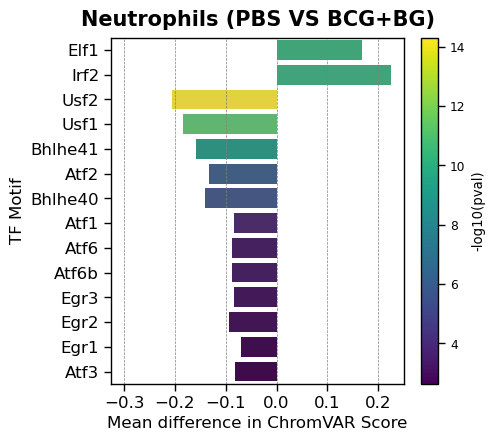

In [8]:
tf_list = ['Irf2_636', 'Elf1_285', 
           'Usf1_46','Usf2_95', 'Bhlhe41_56', 'Bhlhe40_55', 'Egr1_190', 'Egr2_188', 'Egr3_183',
           'Atf1_106', 'Atf2_112', 'Atf3_110' , 'Atf6_111', 'Atf6b_100']
fig1 = barplot_diff_chromvar(tf_list, diff_chromvar_res,title='Neutrophils (PBS VS BCG+BG)')
#fig.savefig("output_plot.png")  # Save the plot if needed

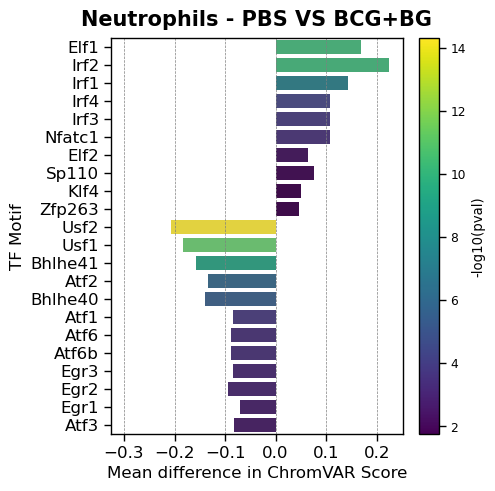

In [9]:
tf_list = ['Elf1_285','Elf2_286','Irf1_631','Irf2_636','Irf3_630','Irf4_632',
           'Nfatc1_703','Sp110_718','Klf4_143','Zfp263_878', 
           'Usf1_46','Usf2_95', 'Bhlhe41_56', 'Bhlhe40_55', 'Egr1_190', 'Egr2_188', 'Egr3_183',
           'Atf1_106', 'Atf2_112', 'Atf3_110' , 'Atf6_111', 'Atf6b_100']
fig2 = barplot_diff_chromvar(tf_list, diff_chromvar_res,title='Neutrophils - PBS VS BCG+BG',fig_size=(5,5))

In [10]:
tf_list = ['Elf1_285','Elf2_286','Irf1_631','Irf2_636','Irf3_630','Irf4_632','Nfatc1_703','Sp110_718',
           'Klf4_143','Zfp263_878','Usf1_46','Usf2_95','Bhlhe41_56','Bhlhe40_55','Egr1_190','Egr2_188', 
           'Egr3_183','Atf1_106', 'Atf2_112', 'Atf3_110' , 'Atf6_111', 'Atf6b_100','Spib_271','Elf5_281',
           'Ehf_275','Etv6_282','Spic_269','Etv2_270','Klf6_794','Zfp263_878','Fev_291','Fli1_277','Elk3_272',
           'Elf1_285','Irf1_631','Stat2_758','Elf5_281','Irf4_632','Irf7_633','Irf3_630','Nfatc1_703','Rela_698',
           'Foxo1_314','Irf5_635','Foxl1_377','Elf4_283','Hsf2_625','Elf2_286','Nfatc2_700','Ebf1_90','Nr4a3_679',
           'Sp110_718','Klf2_819','Klf3_804','Klf1_214','Klf4_143','Runx1_712']
tf_list = sorted(set(tf_list))

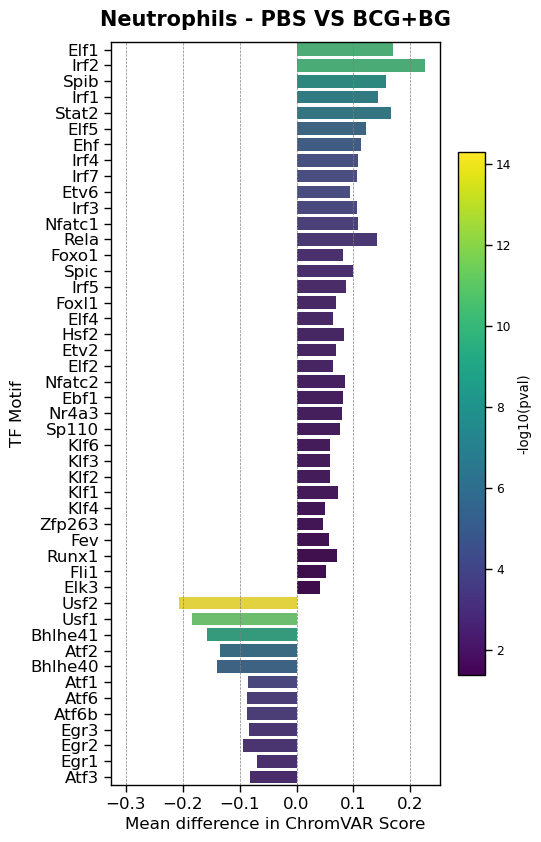

In [11]:
fig3 = barplot_diff_chromvar(tf_list, diff_chromvar_res,title='Neutrophils - PBS VS BCG+BG',fig_size=(5.5,8.5))

In [13]:
fig3.savefig(os.path.join(out_dir,'Neutophils_barplot.png'),dpi=300)

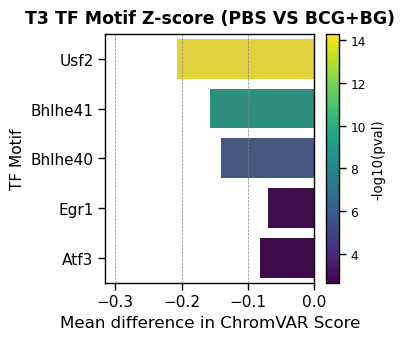

In [15]:
tf_list = ['Usf2_95','Bhlhe41_56','Bhlhe40_55','Egr1_190','Atf3_110']
fig4 = barplot_diff_chromvar(tf_list, diff_chromvar_res,title='T3 TF Motif Z-score (PBS VS BCG+BG)',fig_size=(4, 3.5))
fig4.savefig("T3_motif_barplot.png")  # Save the plot if needed

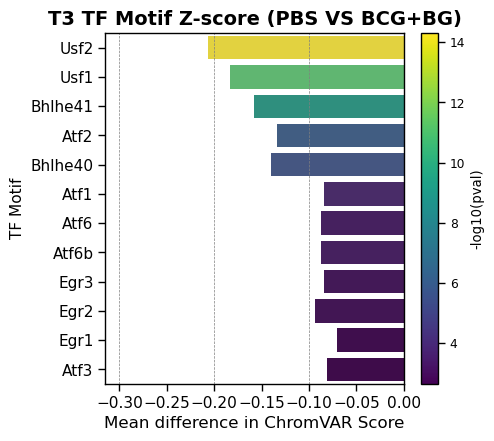

In [13]:
tf_list = ['Usf1_46','Usf2_95', 'Bhlhe41_56', 'Bhlhe40_55', 'Egr1_190', 'Egr2_188', 'Egr3_183',
           'Atf1_106', 'Atf2_112', 'Atf3_110' , 'Atf6_111', 'Atf6b_100']
fig5 = barplot_diff_chromvar(tf_list, diff_chromvar_res,title='T3 TF Motif Z-score (PBS VS BCG+BG)')
fig5.savefig("T3_motif_barplot.pdf")

In [14]:
with PdfPages(os.path.join(out_dir,'01_Neutophils_figures.pdf')) as pdf:
    pdf.savefig(fig1)
    pdf.savefig(fig2)
    pdf.savefig(fig3)
    plt.close()

# Volcano plots

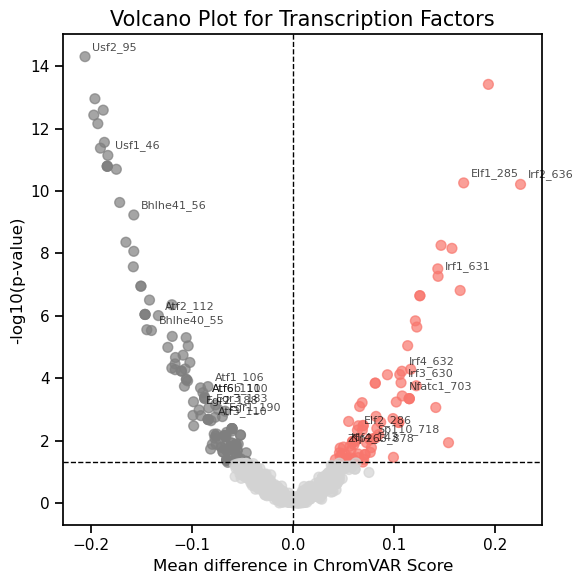

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_volcano(tf_list, diff_chromvar_res):
    # Calculate -log10(pval)
    diff_chromvar_res['-log10(pval)'] = -np.log10(diff_chromvar_res['pval'])
    
    # Apply the coloring rules
    def assign_color(row):
        if row['pval'] > 0.05:
            return 'lightgrey'
        elif row['MeanDiff'] < 0 and row['pval'] < 0.05:
            return '#7f7f7f'
        elif row['MeanDiff'] > 0 and row['pval'] < 0.05:
            return '#F8766D'
        else:
            return 'lightgrey'  # Default color

    diff_chromvar_res['color'] = diff_chromvar_res.apply(assign_color, axis=1)
    
    # Plotting the volcano plot
    plt.figure(figsize=(6, 6))
    sns.set_context("notebook")

    # Scatter plot
    plt.scatter(diff_chromvar_res['MeanDiff'], diff_chromvar_res['-log10(pval)'], 
                c=diff_chromvar_res['color'], s=50, alpha=0.7)

    # Annotate the TFs in the tf_list
    for index, row in diff_chromvar_res.iterrows():
        if row['name'] in tf_list:
            plt.annotate(row['name'], 
                         (row['MeanDiff'], row['-log10(pval)']),
                         fontsize=8, 
                         alpha=0.7,
                         color='black',
                         xytext=(5, 5),  # offset for annotation
                         textcoords='offset points')

    # Labels and title
    plt.xlabel('Mean difference in ChromVAR Score', fontsize=12)
    plt.ylabel('-log10(p-value)', fontsize=12)
    plt.title('Volcano Plot for Transcription Factors', fontsize=15)

    # Add vertical and horizontal lines for threshold
    plt.axhline(y=1.3, color='k', linestyle='--', linewidth=1)  # Example threshold for pval (y-axis)
    plt.axvline(x=0, color='k', linestyle='--', linewidth=1)  # x=0, for MeanDiff threshold
    
    # Show plot
    plt.tight_layout()
    plt.show()

# Usage example:
# plot_volcano(tf_list, diff_chromvar_res)
plot_volcano(tf_list, diff_chromvar_res)